In [1]:
import re
import numpy as np
from zipfile import ZipFile
import xmltodict
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Explore Posts and Tags

In [12]:
z = ZipFile('../data/original/Posts.zip')

In [13]:
f = z.open('Posts.xml')

In [14]:
for _ in range(3):
    f.readline()

In [15]:
filter_re = re.compile(r'(<[^>]+>)|(&[a-z]{2,5};)')

In [21]:
token_re = re.compile(r'([a-zA-Z\.\-$#][0-9a-zA-Z\.\-$#]+[\.\?\!]*)')

In [22]:
def tokenize_body(body):
    return token_re.findall(filter_re.sub(' ', body))

In [23]:
def filter_body(body):
    return ' '.join(tokenize_body(body))

In [50]:
posts_min = open('../data/original/posts_min.tsv', 'w')

In [51]:
buffer = []
for line in tqdm_notebook(f):
    try:
        r = xmltodict.parse(f.readline())
    except:
        posts_min.writelines(buffer)
        buffer = []
        posts_min.flush()
    
    if r['row']['@PostTypeId'] != '1':
        continue
    score = r['row']['@Score']
    post_id = r['row']['@Id']
    tags = ''
    if '@Tags' in r['row']:
        tags = r['row']['@Tags']
    
    body_len = len(tokenize_body(r['row']['@Body']))
    
    buffer.append("{}\t{}\t{}\t{}\n".format(post_id, score, body_len, tags))
    if(len(buffer) >= 50000):
        posts_min.writelines(buffer)
        buffer = []
        posts_min.flush()

In [62]:
posts_min.close()

In [59]:
import seaborn as sb

In [53]:
import pandas as pd

In [58]:
df = pd.read_csv('../data/original/posts_min.tsv', sep='\t')

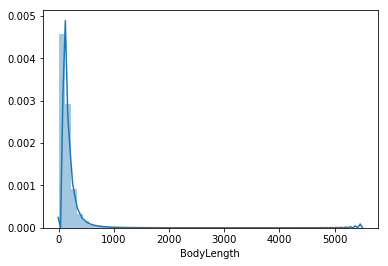

In [60]:
sb.distplot(df['BodyLength'])

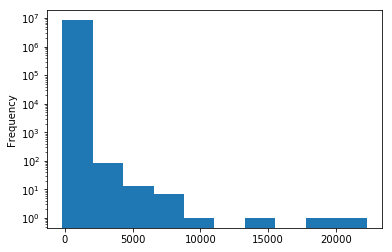

In [11]:
df['Score'].plot(kind='hist', logy=True)

In [12]:
tags = df.Tags.str.findall(r'<([^<>]+)>')

In [13]:
from collections import Counter
from itertools import chain

In [14]:
tag_counts = Counter(chain(*tags.tolist()))

In [15]:
tag_counts.most_common(50)

[('javascript', 863192),
 ('java', 744127),
 ('c#', 632969),
 ('php', 621838),
 ('android', 577642),
 ('python', 534459),
 ('jquery', 468400),
 ('html', 395066),
 ('c++', 298190),
 ('ios', 292366),
 ('css', 282061),
 ('mysql', 270927),
 ('sql', 233843),
 ('asp.net', 170364),
 ('ruby-on-rails', 149949),
 ('c', 144914),
 ('objective-c', 143484),
 ('arrays', 141271),
 ('.net', 138730),
 ('r', 133386),
 ('angularjs', 128523),
 ('node.js', 126312),
 ('json', 124697),
 ('sql-server', 123391),
 ('iphone', 110064),
 ('swift', 107423),
 ('ruby', 100242),
 ('regex', 99312),
 ('ajax', 97485),
 ('django', 92961),
 ('excel', 91413),
 ('xml', 89163),
 ('asp.net-mvc', 88770),
 ('linux', 85441),
 ('database', 75388),
 ('wpf', 72767),
 ('spring', 71816),
 ('wordpress', 71235),
 ('angular', 71131),
 ('vba', 67669),
 ('string', 66767),
 ('python-3.x', 66269),
 ('xcode', 64693),
 ('windows', 62758),
 ('vb.net', 60729),
 ('html5', 58628),
 ('eclipse', 57669),
 ('reactjs', 56272),
 ('multithreading', 56026)

In [16]:
tags_to_consider = set([x[0] for x in tag_counts.most_common(100)])

In [17]:
sum([tag_counts[tag] for tag in tags_to_consider])

11619618

# Load Posts to DB

In [44]:
z = ZipFile('../data/original/Posts.zip')
f = z.open('Posts.xml')
for _ in range(3):
    f.readline()

In [45]:
tags_re = re.compile(r'<([^<>]+)')
def extract_tags(tags_text):
    return set(tags_re.findall(tags_text))

In [46]:
import sqlite3

In [9]:
con = sqlite3.connect('../data/original/filtered_posts.db')

In [10]:
cur = con.cursor()

In [11]:
cur.execute('create table Posts('\
            'Id int primary key,'\
            'Score int,'\
            'Title text,'\
            'Body text,'
            'Tags text'\
            ');')

In [47]:
buffer = []
for line in tqdm_notebook(f):
    try:
        r = xmltodict.parse(f.readline())
    except:
        cur.executemany('insert or ignore into Posts values(?, ?, ?, ?, ?)', buffer)
        con.commit()
        buffer = []
        break     
    
    if r['row']['@PostTypeId'] != '1' or not '@Tags' in r['row']:
        continue
    
    tags = extract_tags(r['row']['@Tags'])
        
    score = int(r['row']['@Score'])
    post_id = int(r['row']['@Id'])
    title = r['row']['@Title']
    
    body_tokens = tokenize_body(r['row']['@Body'])[:500]
    body = ' '.join(body_tokens)
    

    buffer.append((post_id, score, title, body, ' '.join(tags)))
    
    if(len(buffer) >= 50000):
        cur.executemany('insert or ignore into Posts values(?, ?, ?, ?, ?);', buffer)
        con.commit()
        buffer = []

14709098it [40:28, 6056.68it/s]

OperationalError: table Posts has 5 columns but 4 values were supplied

In [50]:
con.close()

In [51]:
z.close()

# Extract Duplicate and Linked Post ids

In [57]:
from collections import defaultdict
import pickle

In [28]:
con = sqlite3.connect('../data/original/filtered_posts.db')
cur = con.cursor()

In [29]:
posts_of_interest = set([x[0] for x in cur.execute('select Id from Posts;')])

In [30]:
z = ZipFile('../data/original/PostLinks.zip')
f = z.open('PostLinks.xml')
for _ in range(3):
    f.readline()

In [31]:
similar_posts = defaultdict(set)
for line in tqdm_notebook(f):
    try:
        r = xmltodict.parse(line)
    except:
        break
    
    post_id = int(r['row']['@PostId'])
    rel_post_id = int(r['row']['@RelatedPostId'])
    
    if not (post_id in posts_of_interest or rel_post_id in posts_of_interest):
        continue
    
    if rel_post_id in similar_posts:
        similar_posts[rel_post_id].add(post_id)
    else:
        similar_posts[post_id].add(rel_post_id)

21424928it [42:00, 8500.64it/s]


In [32]:
len(similar_posts)

2121287

In [33]:
similar_post_lists = []
for k, v in similar_posts.items():
    similar_post_lists.append([k] + list(v))

In [34]:
with open('../data/original/similar_post_ids.pkl', 'wb') as pkl_file:
    pickle.dump(similar_post_lists, pkl_file)

# Adding All the Duplicate and Linked Questions to the DB

In [52]:
from itertools import chain

In [53]:
con = sqlite3.connect('../data/original/filtered_posts.db')

In [54]:
cur = con.cursor()

In [55]:
z = ZipFile('../data/original/Posts.zip')
f = z.open('Posts.xml')
for _ in range(3):
    f.readline()

In [58]:
with open('../data/original/similar_post_ids.pkl', 'rb') as pkl_file:
    similar_post_lists = pickle.load(pkl_file)

In [60]:
post_ids_to_retreive = set(chain(*similar_post_lists))

In [61]:
buffer = []
for line in tqdm_notebook(f):
    try:
        r = xmltodict.parse(f.readline())
    except:
        cur.executemany('insert or ignore into Posts values(?, ?, ?, ?, ?)', buffer)
        con.commit()
        buffer = []
        break
        
    if r['row']['@PostTypeId'] != '1' or not int(r['row']['@Id']) in post_ids_to_retreive:
        continue
    
    post_id = int(r['row']['@Id'])
    tags = extract_tags(r['row']['@Tags'])
    score = int(r['row']['@Score'])
    title = r['row']['@Title']
    
    body_tokens = tokenize_body(r['row']['@Body'])[:500]
    body = ' '.join(body_tokens)

    buffer.append((post_id, score, title, body, ' '.join(tags)))
    
    if(len(buffer) >= 50000):
        cur.executemany('insert or ignore into Posts values(?, ?, ?, ?, ?);', buffer)
        con.commit()
        buffer = []


21424922it [55:47, 6400.00it/s]

In [64]:
z.close()

In [63]:
con.close()

In [65]:
f.close()

# Create Embedding Training File

In [71]:
import re
import nltk
from nltk.corpus import stopwords

In [129]:
stop_en = stopwords.words('english')

In [130]:
token_re = re.compile(r'([a-zA-Z$#][\.\-]*[0-9a-zA-Z\.\-$#]*[0-9a-zA-Z$#])')

In [131]:
def process_text(text):
    words = token_re.findall(text.lower())
    return ' '.join([w for w in words if not w in stop_en])

In [132]:
sentence_split_re = re.compile(r'[\.\?\!]\s')

In [133]:
with open('../data/original/similar_post_ids.pkl', 'rb') as pkl_file:
    similar_post_lists = pickle.load(pkl_file)

In [134]:
con = sqlite3.connect('../data/original/filtered_posts.db')

In [135]:
cur = con.cursor()

In [136]:
similar_questions_data_f = open('../data/original/similar_post_data.tsv', 'w', encoding='utf-8')

In [138]:
buffer = []
for link in tqdm_notebook(similar_post_lists):
    link = map(str, link)
    posts = list(cur.execute('select Title || ". " || Body from Posts where Id in ({});'.format(','.join(link))))
    
    
    sentences = []
    for post in posts:
        for sentence in sentence_split_re.split(post[0]):
            sentences.append(process_text(sentence))
        
    buffer.append('\t'.join(sentences) + '\n')
    if len(buffer) >= 50000:
        similar_questions_data_f.writelines(buffer)
        similar_questions_data_f.flush()
        buffer = []

similar_questions_data_f.writelines(buffer)
similar_questions_data_f.flush()
similar_questions_data_f.close()
buffer = []
        

In [139]:
con.close()